In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import loompy
import matplotlib.pyplot as plt
import scipy.optimize
import velocyto as vcy
import glob
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import pickle
import pixiedust
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

Pixiedust database opened successfully


In [2]:
!mkdir data
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

mkdir: cannot create directory ‘data’: File exists


('data/hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7fbc8cdebdd0>)

In [3]:
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")

# Test the VelocytoLoom Class
## 1. Spliced features

In [4]:
# Spliced features
print(vlm.S,'\nShape:',vlm.S.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
Shape: (32738, 1720)


(array([5.2721378e+07, 2.2718640e+06, 1.1494690e+06, 1.6367200e+05,
        1.9310000e+03, 6.2600000e+02, 2.9200000e+02, 9.7000000e+01,
        2.2000000e+01, 5.0000000e+00, 4.0000000e+00]),
 array([   0,    1,    2,   10,  100,  240,  360,  480,  600,  800, 1000,
        1195]),
 <a list of 11 Patch objects>)

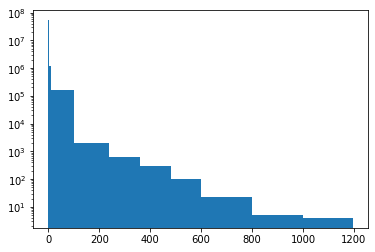

In [5]:
np.histogram(vlm.S, bins=[0,1,2,10,100,240,360,480,600,800,1000,1195])
plt.hist(vlm.S.flatten(),bins=[0,1,2,10,100,240,360,480,600,800,1000,1195],log=True)

In [6]:
# the feature is very sparse, only 6.4% non-zeros 
(vlm.S.flatten()>0).sum() / len(vlm.S.flatten())

0.06371910460356857

## 2. UnSpliced features

In [7]:
# UnSpliced features
print(vlm.U,'\nShape:',vlm.U.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
Shape: (32738, 1720)


(array([5.3927716e+07, 1.6675770e+06, 6.4391500e+05, 6.3785000e+04,
        5.1160000e+03, 8.4100000e+02, 2.2100000e+02, 1.1100000e+02,
        5.6000000e+01, 1.8000000e+01, 4.0000000e+00]),
 array([  0,   1,   2,   6,  18,  36,  54,  71,  90, 110, 130, 178]),
 <a list of 11 Patch objects>)

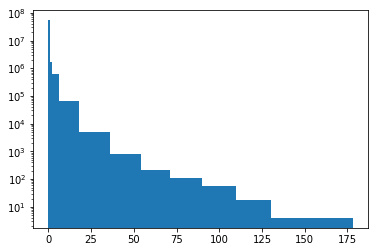

In [8]:
np.histogram(vlm.U, bins=[0,1,2,6,18,36,54,71,90,130,178])
plt.hist(vlm.U.flatten(),bins=[0,1,2,6,18,36,54,71,90,110,130,178],log=True)

In [9]:
# the feature is very sparse, only 4.3% non-zeros 
(vlm.U.flatten()>0).sum() / len(vlm.U.flatten())

0.04229570359172969

## <span style="color:red">U和S还能在同一个位置同时非0，这怎么理解？！一个序列不是要么U要么S吗</span>
Only can guess and assume for now, that this data has been processed and somehow combine the unsliced and sliced seq for a single gene position.

And if that is so, we need the the actual raw data.

In [10]:
vlm.S[vlm.U>0].max()

1195

In [11]:
# columns
vlm.ca

{'CellID': array(['10X_17_028:AACCATGGTAATCACCx', '10X_17_028:AACCATGCATACTACGx',
        '10X_17_028:AAACCTGGTAAAGGAGx', ...,
        '10X_17_029:TTTGGTTGTACCCAATx', '10X_17_029:TTTCCTCCAGTCCTTCx',
        '10X_17_029:TTTGCGCCACAGATTCx'], dtype=object),
 'Clusters': array([3, 3, 1, ..., 6, 0, 1])}

In [12]:
len(vlm.ca['CellID']) # 1720 cells

1720

In [13]:
# rows
vlm.ra

{'Accession': array(['ENSG00000237613', 'ENSG00000238009', 'ENSG00000239945', ...,
        'ENSG00000240450', 'ENSG00000172288', 'ENSG00000231141'],
       dtype=object),
 'Chromosome': array(['1', '1', '1', ..., 'Y', 'Y', 'Y'], dtype=object),
 'End': array([   36081,   133566,    91105, ..., 27632852, 27771049, 27879535]),
 'Gene': array(['FAM138A', 'RP11-34P13.7', 'RP11-34P13.8', ..., 'CSPG4P1Y', 'CDY1',
        'TTTY3'], dtype=object),
 'Start': array([   34554,    89295,    89551, ..., 27629055, 27768264, 27874637]),
 'Strand': array(['-', '-', '-', ..., '+', '+', '+'], dtype=object)}

In [14]:
len(vlm.ra['Gene'])  # 32738 genes

32738

In [15]:
vlm.initial_cell_size

array([5924, 5998, 4594, ..., 8717, 8169, 5731], dtype=uint64)

In [16]:
from IPython.core.debugger import set_trace

In [20]:
%%pixie_debugger
vlm.plot_fractions()

## <span style="color:red">the '10X_17_028' something is the tissue sample the cell comes from? So they have different tissues for this one dataset?! That should be impossible, otherwise how are we estimating differential relations among different tissues?!</span>

In [24]:
np.unique([i.split(":")[0] for i in vlm.ca["CellID"]], return_inverse=1)

(array(['10X_17_028', '10X_17_029'], dtype='<U10'),
 array([0, 0, 0, ..., 1, 1, 1]))